In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [56]:
# Load the data
data_maja = pd.read_csv('../experiment_code/pilot_data/2024-07-10_maja.csv')
data_maja['duration'] = '0:45'
data_miriam = pd.read_csv('../experiment_code/pilot_data/2024-07-18_miriam.csv')
data_eleonora = pd.read_csv('../experiment_code/pilot_data/2024-07-24_eleonora.csv')
data_tim = pd.read_csv('../experiment_code/pilot_data/2024-07-25_tim.csv')

# Remove the last row for each DataFrame except data_maja because that row was just for duration but repeats the previous trial's data
data_miriam = data_miriam.iloc[:-1]
data_eleonora = data_eleonora.iloc[:-1]
data_tim = data_tim.iloc[:-1]

# Combine all DataFrames into one
data = pd.concat([data_maja, data_miriam, data_eleonora, data_tim])

In [57]:
data.head()

,expName,curec_ID,trial_schedule,session_nr,date,end_date,participant,age,gender,max_strength,...,result,points,cumulative_points,effort_trace,effort_expended,effort_response_time,final_bonus_payment,duration,start_time,end_time
0,reward-effort-pgACC-TUS,R88533/RE002,A_1,1,2024-07-10_11h25.03.325,NaN,999,28.0,f,2.989899,...,success,95,95,"[0.6736549865779348, 0.6532411991058761, 0.643...",62.023384,1.885231,NaN,0:45,NaN,NaN
1,reward-effort-pgACC-TUS,R88533/RE002,A_1,1,2024-07-10_11h25.03.325,NaN,999,28.0,f,2.989899,...,NaN,0,95,NaN,NaN,NaN,NaN,0:45,NaN,NaN
2,reward-effort-pgACC-TUS,R88533/RE002,A_1,1,2024-07-10_11h25.03.325,NaN,999,28.0,f,2.989899,...,success,119,214,"[2.5108958590632113, 2.8068957774080614, 2.980...",70.550900,1.543105,NaN,0:45,NaN,NaN
3,reward-effort-pgACC-TUS,R88533/RE002,A_1,1,2024-07-10_11h25.03.325,NaN,999,28.0,f,2.989899,...,success,74,288,"[1.1125514172271953, 1.1227583109632244, 1.255...",86.743750,1.671264,NaN,0:45,NaN,NaN
4,reward-effort-pgACC-TUS,R88533/RE002,A_1,1,2024-07-10_11h25.03.325,NaN,999,28.0,f,2.989899,...,NaN,0,288,NaN,NaN,NaN,NaN,0:45,NaN,NaN


### Acceptance rates

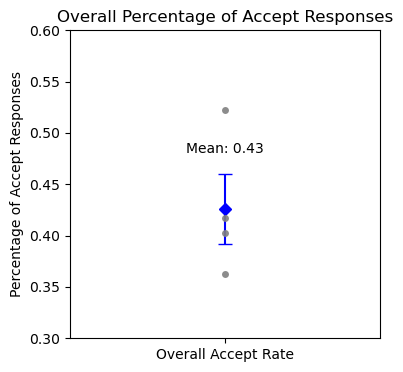

In [58]:
# Overall percentage of 'accept' responses 
participant_percent_accept = data.groupby('participant')['response'].apply(lambda x: (x == 'accept').mean()).reset_index()
participant_percent_accept.columns = ['participant', 'accept_rate']

# Calculate the overall mean and standard error
overall_mean = participant_percent_accept['accept_rate'].mean()
overall_se = participant_percent_accept['accept_rate'].std() / (len(participant_percent_accept) ** 0.5)

# Plot the individual data points
plt.figure(figsize=(4, 4))
sns.stripplot(x=['Overall Accept Rate'] * len(participant_percent_accept), y=participant_percent_accept['accept_rate'], jitter=False, alpha=0.9, color='grey')

# Plot the mean percentage of 'accept' responses with standard error
plt.errorbar(x=['Overall Accept Rate'], y=[overall_mean], yerr=[overall_se], fmt='D', color='blue', capsize=5)

# Add text label for the mean acceptance rate
plt.text(0, overall_mean + overall_se + 0.02, f'Mean: {overall_mean:.2f}', ha='center')

plt.title('Overall Percentage of Accept Responses')
plt.ylabel('Percentage of Accept Responses')
plt.ylim(0.3, 0.6)
plt.show()


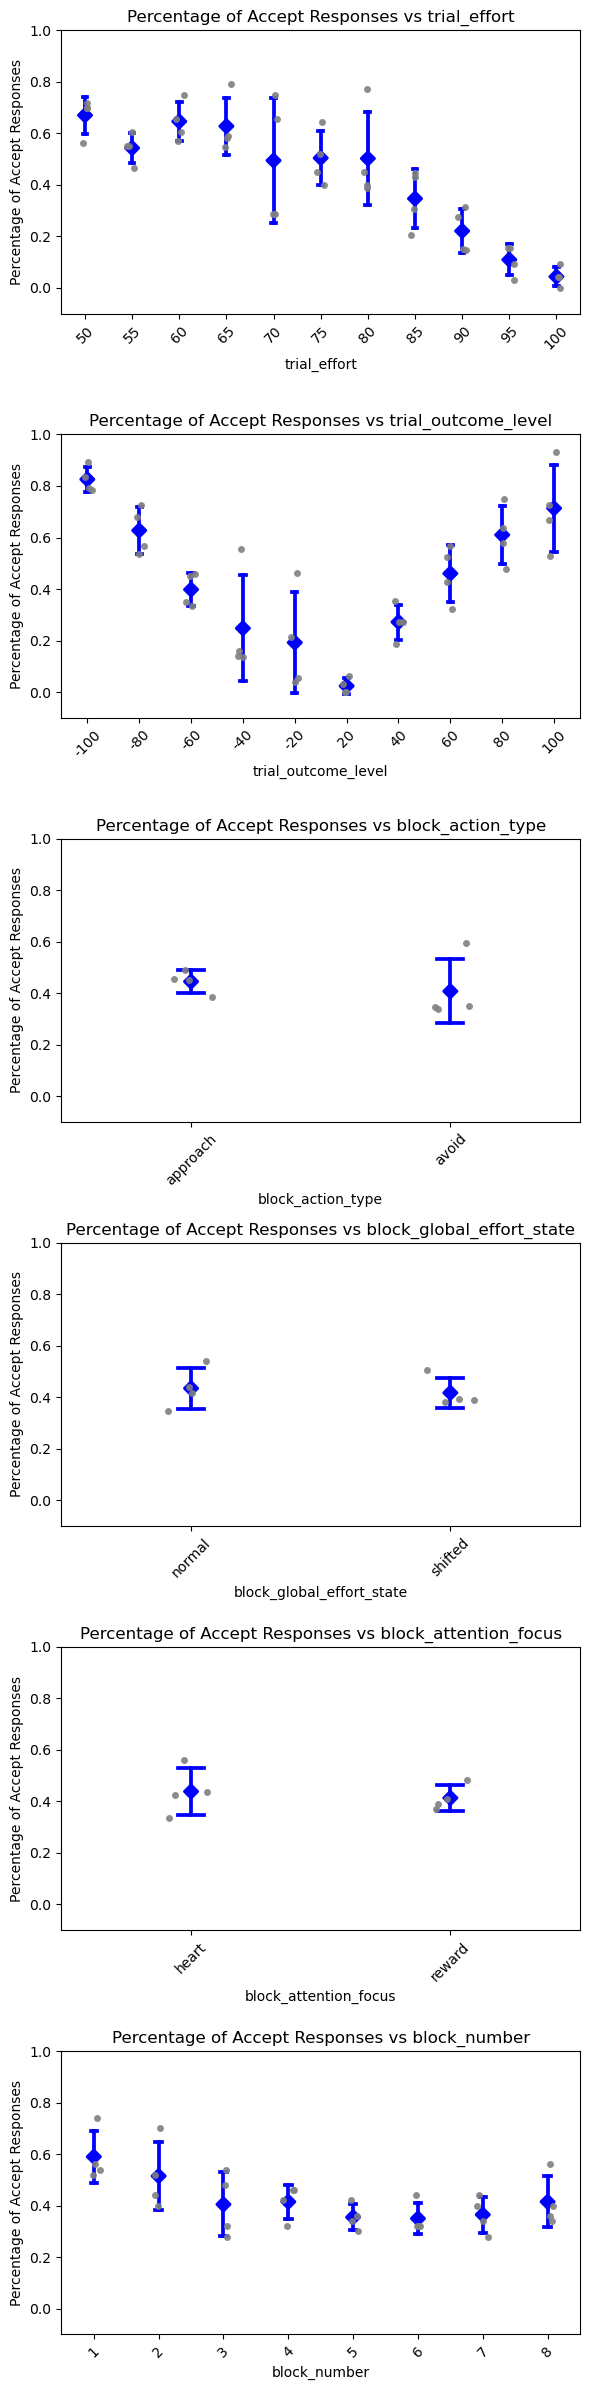

In [59]:
# Define the variables to plot
variables_to_plot = ['trial_effort', 'trial_outcome_level', 'block_action_type', 'block_global_effort_state', 'block_attention_focus', 'block_number']

# Create a figure with subplots
n_vars = len(variables_to_plot)
fig, axes = plt.subplots(n_vars, 1, figsize=(6, 4 * n_vars))

for idx, var in enumerate(variables_to_plot):
    # Calculate the percentage of 'accept' responses for each participant and each level of the variable
    participant_percent_accept = data.groupby(['participant', var])['response'].apply(lambda x: (x == 'accept').mean()).reset_index()

    # Plot the individual data points
    sns.stripplot(ax=axes[idx], x=var, y='response', data=participant_percent_accept, jitter=True, dodge=True, alpha=0.9, color='grey')

    # Plot the mean percentage of 'accept' responses with standard error
    sns.pointplot(ax=axes[idx], x=var, y='response', data=participant_percent_accept, errorbar='sd', join=False, capsize=0.1, markers='D', color='blue')

    axes[idx].set_title(f'Percentage of Accept Responses vs {var}')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Percentage of Accept Responses')
    axes[idx].set_ylim(-0.1, 1)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


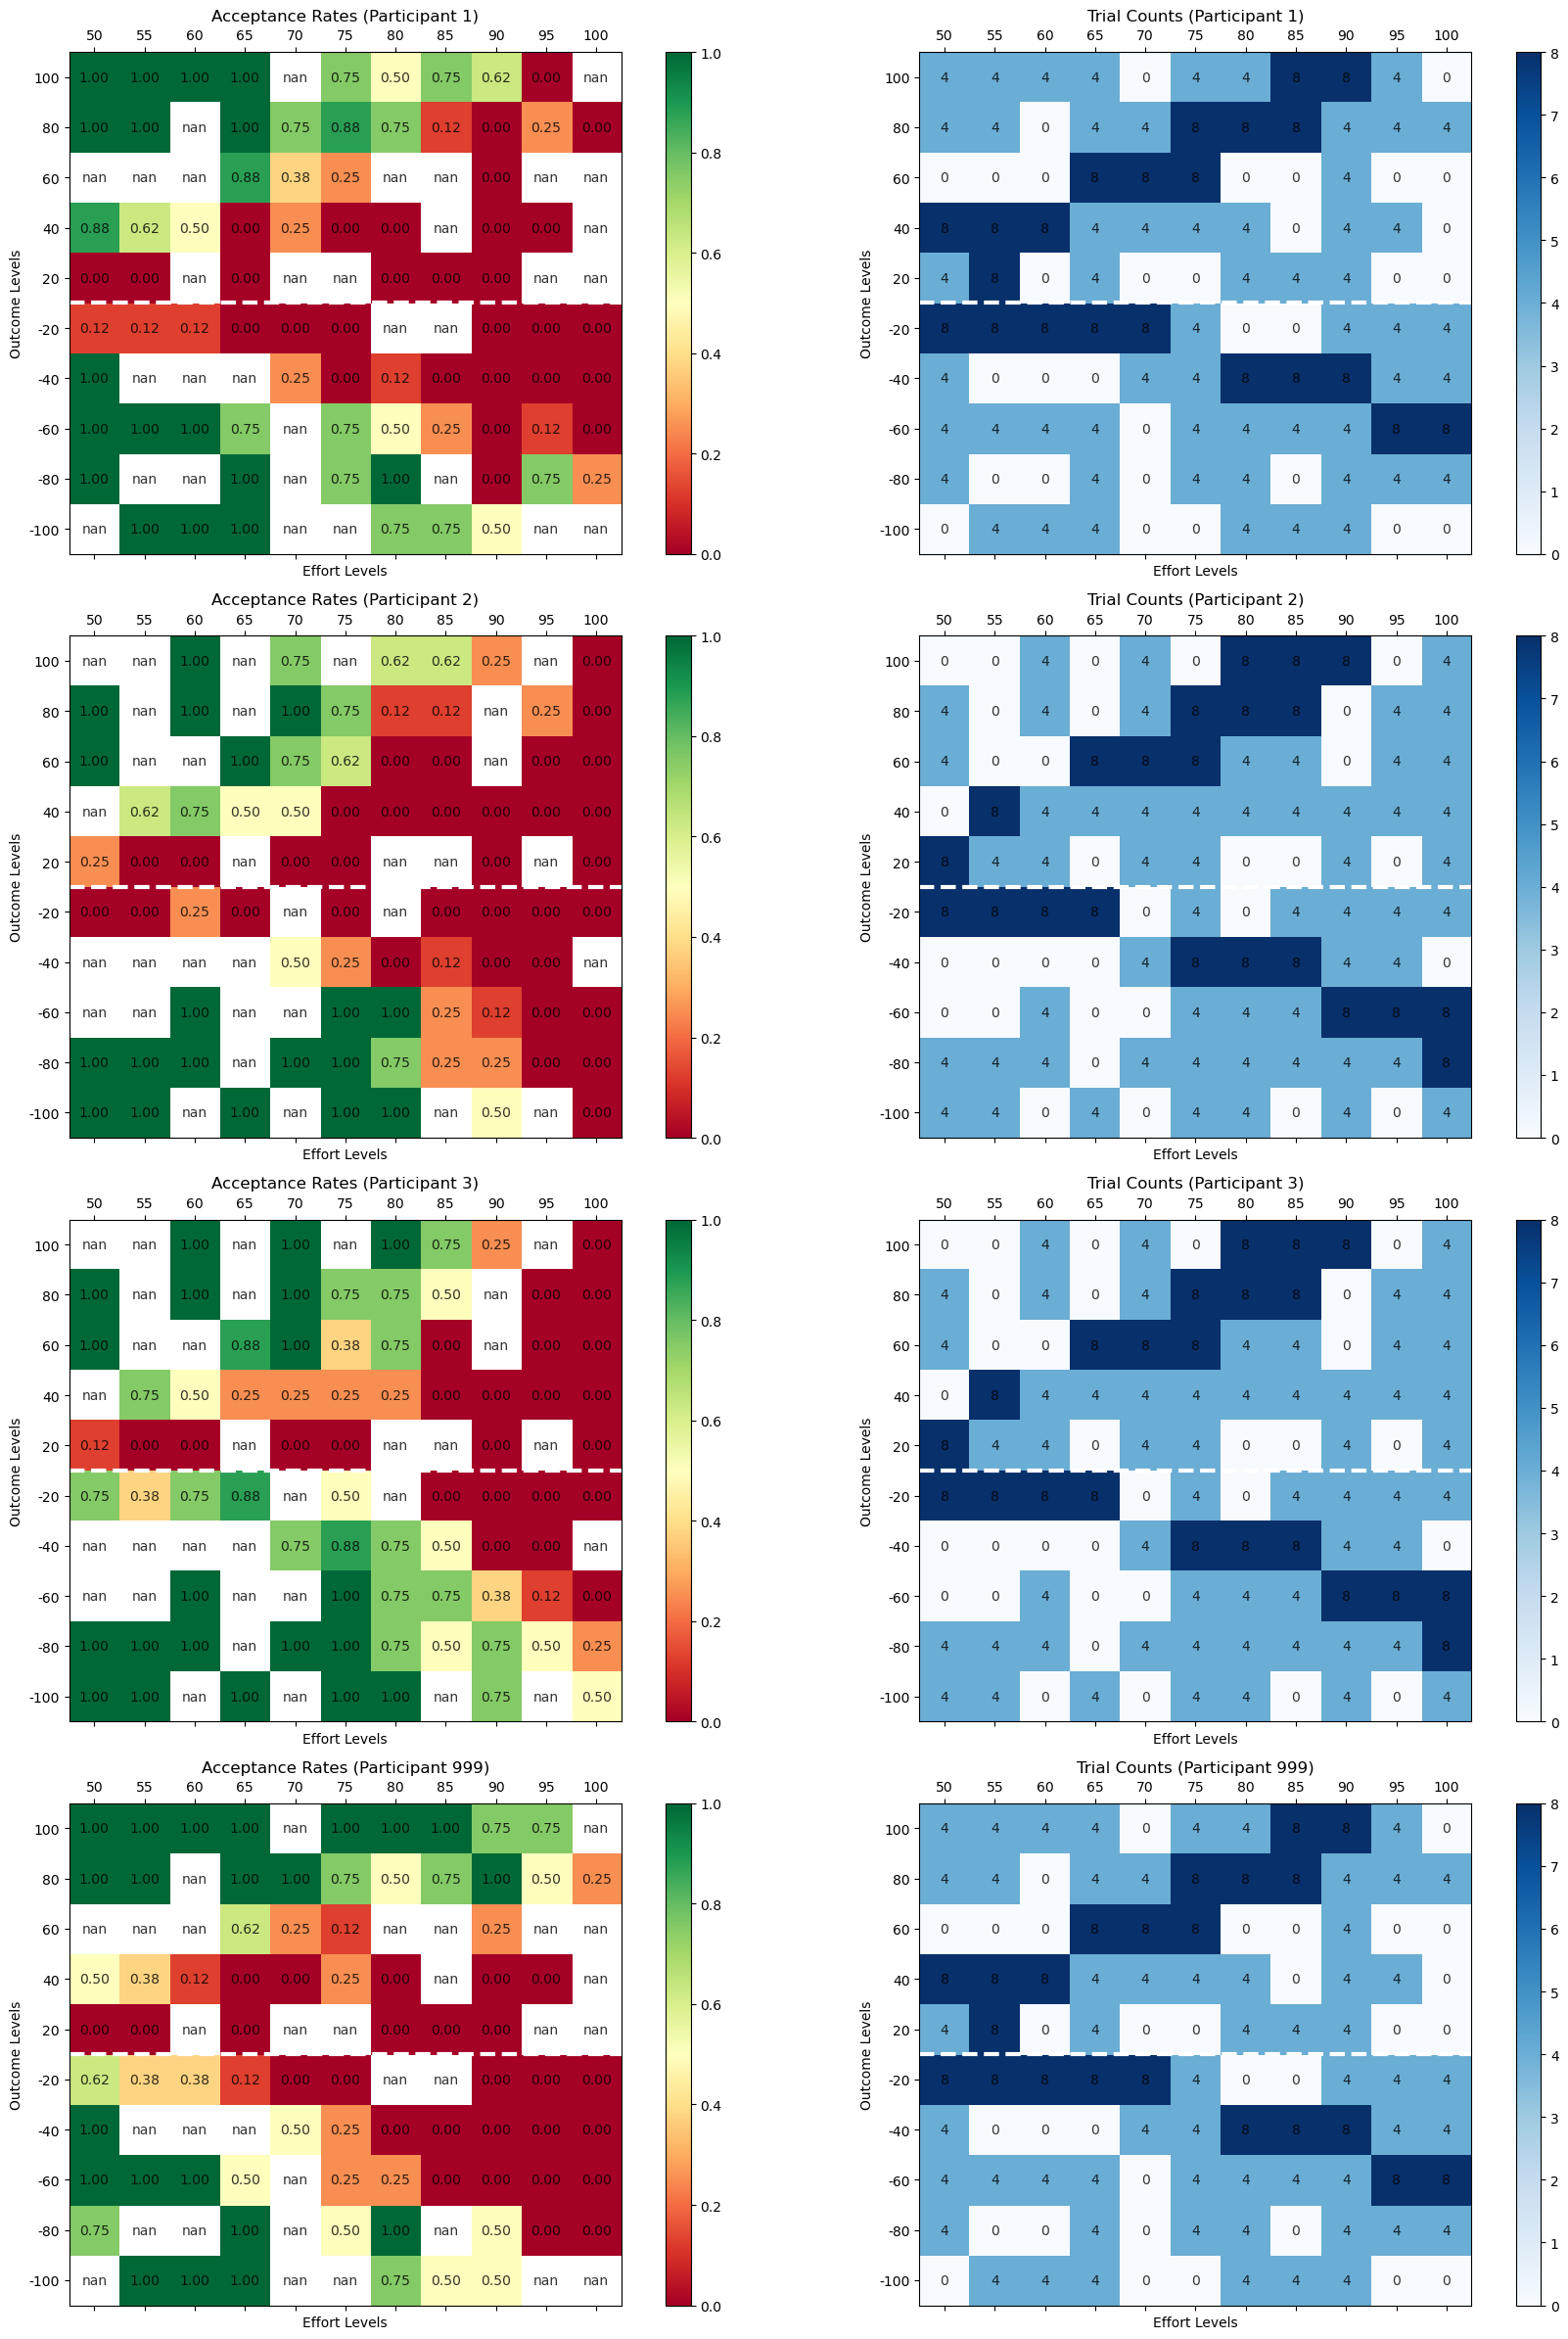

In [60]:
# Group by participant, trial_effort, and trial_outcome_level, then calculate the mean acceptance rate for each group
participant_acceptance_rate = data.groupby(['participant', 'trial_effort', 'trial_outcome_level'])['response'].apply(lambda x: (x == 'accept').mean()).reset_index()

# Calculate the trial counts for each group
participant_trial_counts = data.groupby(['participant', 'trial_effort', 'trial_outcome_level']).size().reset_index(name='trial_count')

# Get the list of unique participants
participants = participant_acceptance_rate['participant'].unique()
effort_levels = sorted(participant_acceptance_rate['trial_effort'].unique())
outcome_levels = sorted(participant_acceptance_rate['trial_outcome_level'].unique())

# Create a complete grid of all possible combinations
all_combinations = pd.MultiIndex.from_product([participants, effort_levels, outcome_levels], names=['participant', 'trial_effort', 'trial_outcome_level']).to_frame(index=False)

# Merge the all_combinations with participant_trial_counts
participant_trial_counts = all_combinations.merge(participant_trial_counts, on=['participant', 'trial_effort', 'trial_outcome_level'], how='left').fillna(0)

# Create a figure with subplots for each participant
n_participants = len(participants)
fig, axes = plt.subplots(n_participants, 2, figsize=(18, 6 * n_participants))

for idx, participant in enumerate(participants):
    # Filter data for the current participant
    participant_data = participant_acceptance_rate[participant_acceptance_rate['participant'] == participant]
    participant_counts = participant_trial_counts[participant_trial_counts['participant'] == participant]

    # Pivot the data to create matrices for the heatmaps
    acceptance_rate_data = participant_data.pivot(index='trial_outcome_level', columns='trial_effort', values='response').values
    count_data = participant_counts.pivot(index='trial_outcome_level', columns='trial_effort', values='trial_count').values

    # Acceptance rate heatmap
    ax1 = axes[idx, 0]
    cax1 = ax1.matshow(acceptance_rate_data, interpolation='nearest', cmap='RdYlGn')
    fig.colorbar(cax1, ax=ax1)

    ax1.set_xticks(np.arange(len(effort_levels)))
    ax1.set_yticks(np.arange(len(outcome_levels)))
    ax1.set_xticklabels(np.array(effort_levels).astype(int))
    ax1.set_yticklabels(np.array(outcome_levels).astype(int))
    ax1.invert_yaxis()

    # Remove grid lines
    ax1.grid(False)

    # Add text labels with mean acceptance rates
    for i in range(len(outcome_levels)):
        for j in range(len(effort_levels)):
            ax1.text(j, i, f'{acceptance_rate_data[i, j]:.2f}', ha='center', va='center', color='black', alpha=0.8)

    lowest_reward_index = np.where(np.array(outcome_levels) == 20)[0][0]
    ax1.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

    ax1.set_xlabel('Effort Levels')
    ax1.set_ylabel('Outcome Levels')
    ax1.set_title(f'Acceptance Rates (Participant {participant})')

    # Trial count heatmap
    ax2 = axes[idx, 1]
    cax2 = ax2.matshow(count_data, interpolation='nearest', cmap='Blues')
    fig.colorbar(cax2, ax=ax2)

    ax2.set_xticks(np.arange(len(effort_levels)))
    ax2.set_yticks(np.arange(len(outcome_levels)))
    ax2.set_xticklabels(np.array(effort_levels).astype(int))
    ax2.set_yticklabels(np.array(outcome_levels).astype(int))
    ax2.invert_yaxis()

    # Remove grid lines
    ax2.grid(False)

    # Add text labels with trial counts
    for i in range(len(outcome_levels)):
        for j in range(len(effort_levels)):
            ax2.text(j, i, f'{count_data[i, j]:.0f}', ha='center', va='center', color='black', alpha=0.8)
    
    lowest_reward_index = np.where(np.array(outcome_levels) == 20)[0][0]
    ax2.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

    ax2.set_xlabel('Effort Levels')
    ax2.set_ylabel('Outcome Levels')
    ax2.set_title(f'Trial Counts (Participant {participant})')

plt.tight_layout()
plt.show()


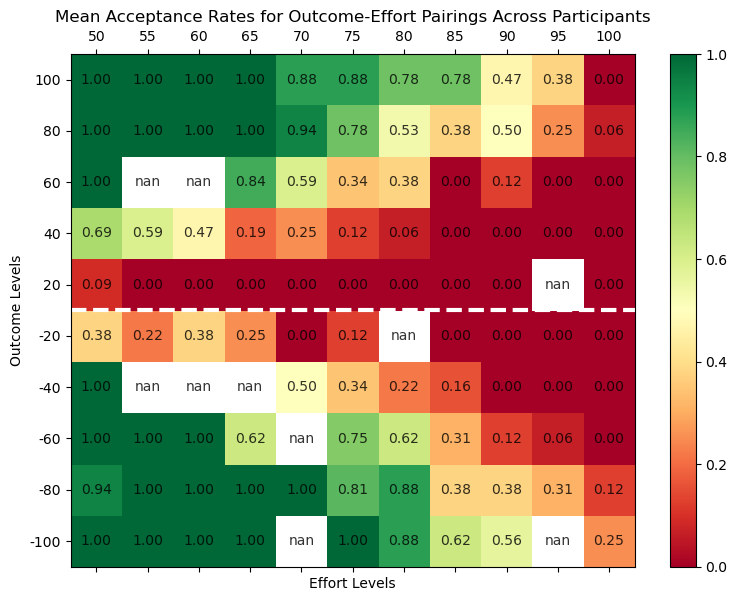

In [61]:
# Group by participant, trial_effort, and trial_outcome_level, then calculate the mean acceptance rate for each group
participant_acceptance_rate = data.groupby(['participant', 'trial_effort', 'trial_outcome_level'])['response'].apply(lambda x: (x == 'accept').mean()).reset_index()

# Calculate the mean acceptance rate across all participants for each combination of trial_effort and trial_outcome_level
mean_acceptance_rate = participant_acceptance_rate.groupby(['trial_effort', 'trial_outcome_level'])['response'].mean().reset_index()

# Pivot the data to create a matrix for the heatmap
heatmap_data = mean_acceptance_rate.pivot(index='trial_outcome_level', columns='trial_effort', values='response').values

# Get the list of unique effort and outcome levels
effort_levels = sorted(participant_acceptance_rate['trial_effort'].unique())
outcome_levels = sorted(participant_acceptance_rate['trial_outcome_level'].unique())

fig, ax = plt.subplots(figsize=(8, 6))

# Acceptance rate heatmap
cax = ax.matshow(heatmap_data, interpolation='nearest', cmap='RdYlGn')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels(np.array(effort_levels).astype(int))
ax.set_yticklabels(np.array(outcome_levels).astype(int))
ax.invert_yaxis()

# Remove grid lines
ax.grid(False)

# Add text labels with mean acceptance rates
for i in range(len(outcome_levels)):
    for j in range(len(effort_levels)):
        ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='black', alpha=0.8)

lowest_reward_index = np.where(np.array(outcome_levels) == 20)[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)

ax.set_xlabel('Effort Levels')
ax.set_ylabel('Outcome Levels')
ax.set_title('Mean Acceptance Rates for Outcome-Effort Pairings Across Participants')

plt.tight_layout()
plt.show()


### Heart / reward ratings

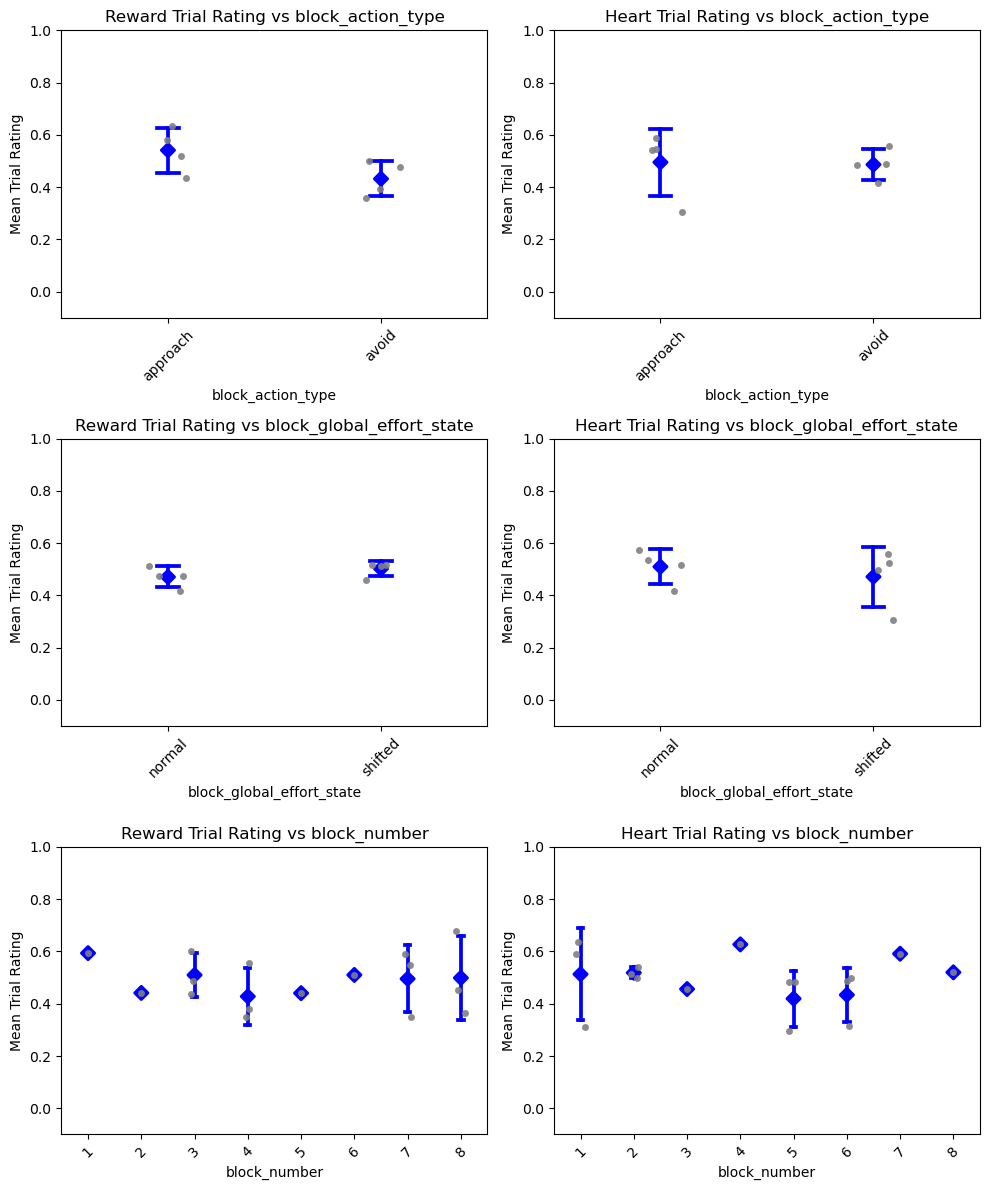

In [62]:
variables_to_plot = ['block_action_type', 'block_global_effort_state', 'block_number']

# Create a figure with subplots
n_vars = len(variables_to_plot)
fig, axes = plt.subplots(n_vars, 2, figsize=(10, 4 * n_vars))

for idx, var in enumerate(variables_to_plot):
    for focus in ['reward', 'heart']:
        # Filter data by block_attention_focus
        focus_data = data[data['block_attention_focus'] == focus]
        
        # Calculate the mean trial_rating for each participant and each level of the variable
        participant_mean_rating = focus_data.groupby(['participant', var])['trial_rating'].mean().reset_index()

        # Determine the axis index based on the focus
        ax_idx = 0 if focus == 'reward' else 1
        
        # Plot the individual data points
        sns.stripplot(ax=axes[idx, ax_idx], x=var, y='trial_rating', data=participant_mean_rating, jitter=True, dodge=True, alpha=0.9, color='grey')

        # Plot the mean trial_rating with standard error
        sns.pointplot(ax=axes[idx, ax_idx], x=var, y='trial_rating', data=participant_mean_rating, errorbar='sd', join=False, capsize=0.1, markers='D', color='blue')

        axes[idx, ax_idx].set_title(f'{focus.capitalize()} Trial Rating vs {var}')
        axes[idx, ax_idx].set_xlabel(var)
        axes[idx, ax_idx].set_ylabel('Mean Trial Rating')
        axes[idx, ax_idx].set_ylim(-0.1, 1)
        axes[idx, ax_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
